In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
# from process_results import process_results, aggregate_results, best_ridge
from scipy.stats import ortho_group
from sklearn.linear_model import LinearRegression, RidgeCV
import scipy.linalg as scl
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)


In [2]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 10
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

In [3]:
cs=sns.color_palette()

## MDL COMP FOR different eigenvalues decay of Matrices

In [4]:
save_data = True

npr.seed(121123)


for noise_std in [0.1, 1.]:
    d0s = np.array([100, 400], dtype=int)
    ds = np.array([5, 10, 20, 40, 60, 80, 100, 200, 400, 800, 1000, 1200, 1600, 2000])
    ns = np.array([200])
    epows = [0., 0.5]

    num_norms = 2
    num_trials = 3
    rmt_mdl_comp = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))
    rmt_mdl_comp_2 = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))
    rmt_mdl_comp_3 = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))


    new_rmt_mdl_comp = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))
    new_rmt_mdl_comp_2 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))
    new_rmt_mdl_comp_3 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))

    dmax = max(ds)

    beta_stars = np.zeros((len(d0s), dmax))
    # initialize beta_Star fixed
    for l, d0 in enumerate(d0s):
        beta_fixed = npr.randn(d0)
        beta_fixed /= npl.norm(beta_fixed)
        beta_stars[l, :d0] = beta_fixed


    for m in tqdm(range(num_trials)):

        # change X_train
        for p, epow in enumerate(epows):

            eigs = np.diag(np.arange(1, dmax+1)**(-epow))
            X_train = npr.randn(max(ns), dmax) @ eigs

            y_train_stars = np.zeros((len(d0s), ns[0]))

            for ltemp, d0 in enumerate(d0s):
                y_train_stars[ltemp, :] = X_train[:, :d0] @ beta_stars[ltemp, :d0]

            for j, d in tqdm(enumerate(ds)):
                for k, n in enumerate(ns):
                    X_train_d = X_train[:n, :d]
                    eigenvals, eigenvecs = scl.eigh(X_train_d.T @ X_train_d)
                    eigenvals = eigenvals[::-1]
                    V, s, Uh = scl.svd(X_train_d, full_matrices=False)

                    for l, d0 in enumerate(d0s):

                        w = eigenvecs.T @ beta_stars[l, :d]
                        w = w[::-1] # arrange in order

                        v = V.T @ y_train_stars[l, :]


                        for i in range(num_norms):
                            print(m, d0, i, d, n)
                            f = (i+1)**2

                            rmt_mdl_comp[m, i, j, k, l, p] = np.sum(np.log(1+f**2 *eigenvals[:min(n, d)] * (w**2/noise_std**2)[:min(n, d)])) / n
                            rmt_mdl_comp_2[m, i, j, k, l, p]  = rmt_mdl_comp[m, i, j, k, l, p] + np.sum(np.log((noise_std**2 / (f**2 * w**2))[:min(n, d)])) / n
                            rmt_mdl_comp_3[m, i, j, k, l, p] = rmt_mdl_comp_2[m, i, j, k, l, p] - np.log(0.005) * min(n, d)/n


                            new_rmt_mdl_comp[m, i, j, k, l, p] = np.sum(np.log(1+f**2 * v**2/noise_std**2)) / n
                            new_rmt_mdl_comp_2[m, i, j, k, l, p] = new_rmt_mdl_comp[m, i, j, k, l, p] + np.sum(np.log( noise_std**2 / (f**2 * v**2))) / n
                            new_rmt_mdl_comp_3[m, i, j, k, l, p] = new_rmt_mdl_comp_2[m, i, j, k, l, p] - np.log(0.005) *min(n, d)/n 

    if save_data:
        results = {'ns': ns, 'd0s': d0s,  'ds' : ds,
                   'epows': epows,
                   'num_trials': num_trials, 
                   'num_norms': num_norms,
                   'noise_var': noise_std**2,
                    'rmt_mdl_comp': rmt_mdl_comp,
                   'rmt_mdl_comp_2':rmt_mdl_comp_2,
                   'rmt_mdl_comp_3' : rmt_mdl_comp_3,
                   'new_rmt_mdl_comp': new_rmt_mdl_comp,
                   'new_rmt_mdl_comp_2': new_rmt_mdl_comp_2,
                   'new_rmt_mdl_comp_3': new_rmt_mdl_comp_3
                  }
        file = open('decay_mdl_n_%d_noise_%d.txt'%(ns[0], noise_std), 'wb')
        pickle.dump(results, file)
        file.close()

    # results = pickle.load(open('decay_mdl_n_200.txt', 'rb'))

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:00, 14.61it/s]

0 100 0 5 200
0 100 1 5 200
0 400 0 5 200
0 400 1 5 200
0 100 0 10 200
0 100 1 10 200
0 400 0 10 200
0 400 1 10 200
0 100 0 20 200
0 100 1 20 200
0 400 0 20 200
0 400 1 20 200



4it [00:00,  9.35it/s]

0 100 0 40 200
0 100 1 40 200
0 400 0 40 200
0 400 1 40 200



5it [00:00,  6.49it/s]

0 100 0 60 200
0 100 1 60 200
0 400 0 60 200
0 400 1 60 200



6it [00:01,  4.73it/s]

0 100 0 80 200
0 100 1 80 200
0 400 0 80 200
0 400 1 80 200



7it [00:01,  3.48it/s]

0 100 0 100 200
0 100 1 100 200
0 400 0 100 200
0 400 1 100 200



8it [00:02,  1.71it/s]

0 100 0 200 200
0 100 1 200 200
0 400 0 200 200
0 400 1 200 200



9it [00:05,  1.07s/it]

0 100 0 400 200
0 100 1 400 200
0 400 0 400 200
0 400 1 400 200



10it [00:09,  2.05s/it]

0 100 0 800 200
0 100 1 800 200
0 400 0 800 200
0 400 1 800 200



11it [00:15,  3.14s/it]

0 100 0 1000 200
0 100 1 1000 200
0 400 0 1000 200
0 400 1 1000 200



12it [00:22,  4.43s/it]

0 100 0 1200 200
0 100 1 1200 200
0 400 0 1200 200
0 400 1 1200 200



13it [00:35,  6.86s/it]

0 100 0 1600 200
0 100 1 1600 200
0 400 0 1600 200
0 400 1 1600 200



14it [00:54, 10.55s/it]

0 100 0 2000 200
0 100 1 2000 200
0 400 0 2000 200
0 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 18.53it/s]

0 100 0 5 200
0 100 1 5 200
0 400 0 5 200
0 400 1 5 200
0 100 0 10 200
0 100 1 10 200
0 400 0 10 200
0 400 1 10 200
0 100 0 20 200
0 100 1 20 200
0 400 0 20 200
0 400 1 20 200



4it [00:00,  7.53it/s]

0 100 0 40 200
0 100 1 40 200
0 400 0 40 200
0 400 1 40 200



5it [00:00,  5.79it/s]

0 100 0 60 200
0 100 1 60 200
0 400 0 60 200
0 400 1 60 200



6it [00:01,  4.51it/s]

0 100 0 80 200
0 100 1 80 200
0 400 0 80 200
0 400 1 80 200



7it [00:01,  3.31it/s]

0 100 0 100 200
0 100 1 100 200
0 400 0 100 200
0 400 1 100 200



8it [00:02,  1.71it/s]

0 100 0 200 200
0 100 1 200 200
0 400 0 200 200
0 400 1 200 200



9it [00:05,  1.09s/it]

0 100 0 400 200
0 100 1 400 200
0 400 0 400 200
0 400 1 400 200



10it [00:09,  2.08s/it]

0 100 0 800 200
0 100 1 800 200
0 400 0 800 200
0 400 1 800 200



11it [00:15,  3.25s/it]

0 100 0 1000 200
0 100 1 1000 200
0 400 0 1000 200
0 400 1 1000 200



12it [00:23,  4.61s/it]

0 100 0 1200 200
0 100 1 1200 200
0 400 0 1200 200
0 400 1 1200 200



13it [00:36,  7.18s/it]

0 100 0 1600 200
0 100 1 1600 200
0 400 0 1600 200
0 400 1 1600 200



 33%|███▎      | 1/3 [01:50<03:40, 110.36s/it]

0 100 0 2000 200
0 100 1 2000 200
0 400 0 2000 200
0 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 19.31it/s]

1 100 0 5 200
1 100 1 5 200
1 400 0 5 200
1 400 1 5 200
1 100 0 10 200
1 100 1 10 200
1 400 0 10 200
1 400 1 10 200
1 100 0 20 200
1 100 1 20 200
1 400 0 20 200
1 400 1 20 200



4it [00:00,  7.33it/s]

1 100 0 40 200
1 100 1 40 200
1 400 0 40 200
1 400 1 40 200



5it [00:00,  5.68it/s]

1 100 0 60 200
1 100 1 60 200
1 400 0 60 200
1 400 1 60 200



6it [00:01,  4.60it/s]

1 100 0 80 200
1 100 1 80 200
1 400 0 80 200
1 400 1 80 200



7it [00:01,  3.49it/s]

1 100 0 100 200
1 100 1 100 200
1 400 0 100 200
1 400 1 100 200



8it [00:02,  1.77it/s]

1 100 0 200 200
1 100 1 200 200
1 400 0 200 200
1 400 1 200 200



9it [00:04,  1.04s/it]

1 100 0 400 200
1 100 1 400 200
1 400 0 400 200
1 400 1 400 200



10it [00:09,  2.09s/it]

1 100 0 800 200
1 100 1 800 200
1 400 0 800 200
1 400 1 800 200



11it [00:15,  3.27s/it]

1 100 0 1000 200
1 100 1 1000 200
1 400 0 1000 200
1 400 1 1000 200



12it [00:22,  4.48s/it]

1 100 0 1200 200
1 100 1 1200 200
1 400 0 1200 200
1 400 1 1200 200



13it [00:35,  6.89s/it]

1 100 0 1600 200
1 100 1 1600 200
1 400 0 1600 200
1 400 1 1600 200



14it [00:53, 10.40s/it]

1 100 0 2000 200
1 100 1 2000 200
1 400 0 2000 200
1 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 21.27it/s]

1 100 0 5 200
1 100 1 5 200
1 400 0 5 200
1 400 1 5 200
1 100 0 10 200
1 100 1 10 200
1 400 0 10 200
1 400 1 10 200
1 100 0 20 200
1 100 1 20 200
1 400 0 20 200
1 400 1 20 200



4it [00:00,  7.93it/s]

1 100 0 40 200
1 100 1 40 200
1 400 0 40 200
1 400 1 40 200



5it [00:00,  6.35it/s]

1 100 0 60 200
1 100 1 60 200
1 400 0 60 200
1 400 1 60 200



6it [00:01,  4.99it/s]

1 100 0 80 200
1 100 1 80 200
1 400 0 80 200
1 400 1 80 200



7it [00:01,  3.63it/s]

1 100 0 100 200
1 100 1 100 200
1 400 0 100 200
1 400 1 100 200



8it [00:02,  1.76it/s]

1 100 0 200 200
1 100 1 200 200
1 400 0 200 200
1 400 1 200 200



9it [00:04,  1.04s/it]

1 100 0 400 200
1 100 1 400 200
1 400 0 400 200
1 400 1 400 200



10it [00:08,  1.97s/it]

1 100 0 800 200
1 100 1 800 200
1 400 0 800 200
1 400 1 800 200



11it [00:14,  3.04s/it]

1 100 0 1000 200
1 100 1 1000 200
1 400 0 1000 200
1 400 1 1000 200



12it [00:21,  4.33s/it]

1 100 0 1200 200
1 100 1 1200 200
1 400 0 1200 200
1 400 1 1200 200



13it [00:34,  6.73s/it]

1 100 0 1600 200
1 100 1 1600 200
1 400 0 1600 200
1 400 1 1600 200



 67%|██████▋   | 2/3 [03:37<01:49, 109.35s/it]

1 100 0 2000 200
1 100 1 2000 200
1 400 0 2000 200
1 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 20.88it/s]

2 100 0 5 200
2 100 1 5 200
2 400 0 5 200
2 400 1 5 200
2 100 0 10 200
2 100 1 10 200
2 400 0 10 200
2 400 1 10 200
2 100 0 20 200
2 100 1 20 200
2 400 0 20 200
2 400 1 20 200



4it [00:00,  8.03it/s]

2 100 0 40 200
2 100 1 40 200
2 400 0 40 200
2 400 1 40 200



5it [00:00,  6.32it/s]

2 100 0 60 200
2 100 1 60 200
2 400 0 60 200
2 400 1 60 200



6it [00:01,  4.87it/s]

2 100 0 80 200
2 100 1 80 200
2 400 0 80 200
2 400 1 80 200



7it [00:01,  3.70it/s]

2 100 0 100 200
2 100 1 100 200
2 400 0 100 200
2 400 1 100 200



8it [00:02,  1.78it/s]

2 100 0 200 200
2 100 1 200 200
2 400 0 200 200
2 400 1 200 200



9it [00:04,  1.02s/it]

2 100 0 400 200
2 100 1 400 200
2 400 0 400 200
2 400 1 400 200



10it [00:09,  2.04s/it]

2 100 0 800 200
2 100 1 800 200
2 400 0 800 200
2 400 1 800 200



11it [00:15,  3.23s/it]

2 100 0 1000 200
2 100 1 1000 200
2 400 0 1000 200
2 400 1 1000 200



12it [00:22,  4.58s/it]

2 100 0 1200 200
2 100 1 1200 200
2 400 0 1200 200
2 400 1 1200 200



13it [00:35,  6.87s/it]

2 100 0 1600 200
2 100 1 1600 200
2 400 0 1600 200
2 400 1 1600 200



14it [00:53, 10.39s/it]

2 100 0 2000 200
2 100 1 2000 200
2 400 0 2000 200
2 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 23.45it/s]

2 100 0 5 200
2 100 1 5 200
2 400 0 5 200
2 400 1 5 200
2 100 0 10 200
2 100 1 10 200
2 400 0 10 200
2 400 1 10 200
2 100 0 20 200
2 100 1 20 200
2 400 0 20 200
2 400 1 20 200



4it [00:00,  7.65it/s]

2 100 0 40 200
2 100 1 40 200
2 400 0 40 200
2 400 1 40 200



5it [00:00,  5.83it/s]

2 100 0 60 200
2 100 1 60 200
2 400 0 60 200
2 400 1 60 200



6it [00:01,  4.52it/s]

2 100 0 80 200
2 100 1 80 200
2 400 0 80 200
2 400 1 80 200



7it [00:01,  3.49it/s]

2 100 0 100 200
2 100 1 100 200
2 400 0 100 200
2 400 1 100 200



8it [00:02,  1.80it/s]

2 100 0 200 200
2 100 1 200 200
2 400 0 200 200
2 400 1 200 200



9it [00:04,  1.04s/it]

2 100 0 400 200
2 100 1 400 200
2 400 0 400 200
2 400 1 400 200



10it [00:08,  1.96s/it]

2 100 0 800 200
2 100 1 800 200
2 400 0 800 200
2 400 1 800 200



11it [00:14,  3.03s/it]

2 100 0 1000 200
2 100 1 1000 200
2 400 0 1000 200
2 400 1 1000 200



12it [00:21,  4.32s/it]

2 100 0 1200 200
2 100 1 1200 200
2 400 0 1200 200
2 400 1 1200 200



13it [00:34,  6.75s/it]

2 100 0 1600 200
2 100 1 1600 200
2 400 0 1600 200
2 400 1 1600 200



  0%|          | 0/3 [00:00<?, ?it/s]

2 100 0 2000 200
2 100 1 2000 200
2 400 0 2000 200
2 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 23.19it/s]

0 100 0 5 200
0 100 1 5 200
0 400 0 5 200
0 400 1 5 200
0 100 0 10 200
0 100 1 10 200
0 400 0 10 200
0 400 1 10 200
0 100 0 20 200
0 100 1 20 200
0 400 0 20 200
0 400 1 20 200



4it [00:00,  7.88it/s]

0 100 0 40 200
0 100 1 40 200
0 400 0 40 200
0 400 1 40 200



5it [00:00,  6.12it/s]

0 100 0 60 200
0 100 1 60 200
0 400 0 60 200
0 400 1 60 200



6it [00:01,  4.84it/s]

0 100 0 80 200
0 100 1 80 200
0 400 0 80 200
0 400 1 80 200



7it [00:01,  3.62it/s]

0 100 0 100 200
0 100 1 100 200
0 400 0 100 200
0 400 1 100 200



8it [00:02,  1.81it/s]

0 100 0 200 200
0 100 1 200 200
0 400 0 200 200
0 400 1 200 200



9it [00:04,  1.03s/it]

0 100 0 400 200
0 100 1 400 200
0 400 0 400 200
0 400 1 400 200



10it [00:09,  2.05s/it]

0 100 0 800 200
0 100 1 800 200
0 400 0 800 200
0 400 1 800 200



11it [00:15,  3.21s/it]

0 100 0 1000 200
0 100 1 1000 200
0 400 0 1000 200
0 400 1 1000 200



12it [00:22,  4.46s/it]

0 100 0 1200 200
0 100 1 1200 200
0 400 0 1200 200
0 400 1 1200 200



13it [00:34,  6.81s/it]

0 100 0 1600 200
0 100 1 1600 200
0 400 0 1600 200
0 400 1 1600 200



14it [00:53, 10.34s/it]

0 100 0 2000 200
0 100 1 2000 200
0 400 0 2000 200
0 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 23.85it/s]

0 100 0 5 200
0 100 1 5 200
0 400 0 5 200
0 400 1 5 200
0 100 0 10 200
0 100 1 10 200
0 400 0 10 200
0 400 1 10 200
0 100 0 20 200
0 100 1 20 200
0 400 0 20 200
0 400 1 20 200



4it [00:00,  8.21it/s]

0 100 0 40 200
0 100 1 40 200
0 400 0 40 200
0 400 1 40 200



5it [00:00,  6.31it/s]

0 100 0 60 200
0 100 1 60 200
0 400 0 60 200
0 400 1 60 200



6it [00:01,  4.91it/s]

0 100 0 80 200
0 100 1 80 200
0 400 0 80 200
0 400 1 80 200



7it [00:01,  3.71it/s]

0 100 0 100 200
0 100 1 100 200
0 400 0 100 200
0 400 1 100 200



8it [00:02,  1.84it/s]

0 100 0 200 200
0 100 1 200 200
0 400 0 200 200
0 400 1 200 200



9it [00:04,  1.01s/it]

0 100 0 400 200
0 100 1 400 200
0 400 0 400 200
0 400 1 400 200



10it [00:08,  1.96s/it]

0 100 0 800 200
0 100 1 800 200
0 400 0 800 200
0 400 1 800 200



11it [00:14,  3.00s/it]

0 100 0 1000 200
0 100 1 1000 200
0 400 0 1000 200
0 400 1 1000 200



12it [00:21,  4.27s/it]

0 100 0 1200 200
0 100 1 1200 200
0 400 0 1200 200
0 400 1 1200 200



13it [00:34,  6.73s/it]

0 100 0 1600 200
0 100 1 1600 200
0 400 0 1600 200
0 400 1 1600 200



 33%|███▎      | 1/3 [01:46<03:32, 106.38s/it]

0 100 0 2000 200
0 100 1 2000 200
0 400 0 2000 200
0 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 23.87it/s]

1 100 0 5 200
1 100 1 5 200
1 400 0 5 200
1 400 1 5 200
1 100 0 10 200
1 100 1 10 200
1 400 0 10 200
1 400 1 10 200
1 100 0 20 200
1 100 1 20 200
1 400 0 20 200
1 400 1 20 200



4it [00:00,  7.55it/s]

1 100 0 40 200
1 100 1 40 200
1 400 0 40 200
1 400 1 40 200



5it [00:00,  6.01it/s]

1 100 0 60 200
1 100 1 60 200
1 400 0 60 200
1 400 1 60 200



6it [00:01,  4.77it/s]

1 100 0 80 200
1 100 1 80 200
1 400 0 80 200
1 400 1 80 200



7it [00:01,  3.64it/s]

1 100 0 100 200
1 100 1 100 200
1 400 0 100 200
1 400 1 100 200



8it [00:02,  1.81it/s]

1 100 0 200 200
1 100 1 200 200
1 400 0 200 200
1 400 1 200 200



9it [00:04,  1.04s/it]

1 100 0 400 200
1 100 1 400 200
1 400 0 400 200
1 400 1 400 200



10it [00:09,  2.05s/it]

1 100 0 800 200
1 100 1 800 200
1 400 0 800 200
1 400 1 800 200



11it [00:15,  3.21s/it]

1 100 0 1000 200
1 100 1 1000 200
1 400 0 1000 200
1 400 1 1000 200



12it [00:22,  4.44s/it]

1 100 0 1200 200
1 100 1 1200 200
1 400 0 1200 200
1 400 1 1200 200



13it [00:34,  6.79s/it]

1 100 0 1600 200
1 100 1 1600 200
1 400 0 1600 200
1 400 1 1600 200



14it [00:53, 10.33s/it]

1 100 0 2000 200
1 100 1 2000 200
1 400 0 2000 200
1 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 21.14it/s]

1 100 0 5 200
1 100 1 5 200
1 400 0 5 200
1 400 1 5 200
1 100 0 10 200
1 100 1 10 200
1 400 0 10 200
1 400 1 10 200
1 100 0 20 200
1 100 1 20 200
1 400 0 20 200
1 400 1 20 200



4it [00:00,  6.99it/s]

1 100 0 40 200
1 100 1 40 200
1 400 0 40 200
1 400 1 40 200



5it [00:00,  5.83it/s]

1 100 0 60 200
1 100 1 60 200
1 400 0 60 200
1 400 1 60 200



6it [00:01,  4.52it/s]

1 100 0 80 200
1 100 1 80 200
1 400 0 80 200
1 400 1 80 200



7it [00:01,  3.51it/s]

1 100 0 100 200
1 100 1 100 200
1 400 0 100 200
1 400 1 100 200



8it [00:02,  1.82it/s]

1 100 0 200 200
1 100 1 200 200
1 400 0 200 200
1 400 1 200 200



9it [00:04,  1.02s/it]

1 100 0 400 200
1 100 1 400 200
1 400 0 400 200
1 400 1 400 200



10it [00:08,  1.96s/it]

1 100 0 800 200
1 100 1 800 200
1 400 0 800 200
1 400 1 800 200



11it [00:14,  3.02s/it]

1 100 0 1000 200
1 100 1 1000 200
1 400 0 1000 200
1 400 1 1000 200



12it [00:21,  4.32s/it]

1 100 0 1200 200
1 100 1 1200 200
1 400 0 1200 200
1 400 1 1200 200



13it [00:34,  6.71s/it]

1 100 0 1600 200
1 100 1 1600 200
1 400 0 1600 200
1 400 1 1600 200



 67%|██████▋   | 2/3 [03:32<01:46, 106.40s/it]

1 100 0 2000 200
1 100 1 2000 200
1 400 0 2000 200
1 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 23.59it/s]

2 100 0 5 200
2 100 1 5 200
2 400 0 5 200
2 400 1 5 200
2 100 0 10 200
2 100 1 10 200
2 400 0 10 200
2 400 1 10 200
2 100 0 20 200
2 100 1 20 200
2 400 0 20 200
2 400 1 20 200



4it [00:00,  7.67it/s]

2 100 0 40 200
2 100 1 40 200
2 400 0 40 200
2 400 1 40 200



5it [00:00,  6.29it/s]

2 100 0 60 200
2 100 1 60 200
2 400 0 60 200
2 400 1 60 200



6it [00:01,  4.95it/s]

2 100 0 80 200
2 100 1 80 200
2 400 0 80 200
2 400 1 80 200



7it [00:01,  3.72it/s]

2 100 0 100 200
2 100 1 100 200
2 400 0 100 200
2 400 1 100 200



8it [00:02,  1.83it/s]

2 100 0 200 200
2 100 1 200 200
2 400 0 200 200
2 400 1 200 200



9it [00:04,  1.03s/it]

2 100 0 400 200
2 100 1 400 200
2 400 0 400 200
2 400 1 400 200



10it [00:09,  2.04s/it]

2 100 0 800 200
2 100 1 800 200
2 400 0 800 200
2 400 1 800 200



11it [00:15,  3.19s/it]

2 100 0 1000 200
2 100 1 1000 200
2 400 0 1000 200
2 400 1 1000 200



12it [00:22,  4.42s/it]

2 100 0 1200 200
2 100 1 1200 200
2 400 0 1200 200
2 400 1 1200 200



13it [00:34,  6.78s/it]

2 100 0 1600 200
2 100 1 1600 200
2 400 0 1600 200
2 400 1 1600 200



14it [00:53, 10.34s/it]

2 100 0 2000 200
2 100 1 2000 200
2 400 0 2000 200
2 400 1 2000 200



0it [00:00, ?it/s]
3it [00:00, 23.01it/s]

2 100 0 5 200
2 100 1 5 200
2 400 0 5 200
2 400 1 5 200
2 100 0 10 200
2 100 1 10 200
2 400 0 10 200
2 400 1 10 200
2 100 0 20 200
2 100 1 20 200
2 400 0 20 200
2 400 1 20 200



4it [00:00,  8.09it/s]

2 100 0 40 200
2 100 1 40 200
2 400 0 40 200
2 400 1 40 200



5it [00:00,  6.10it/s]

2 100 0 60 200
2 100 1 60 200
2 400 0 60 200
2 400 1 60 200



6it [00:01,  4.74it/s]

2 100 0 80 200
2 100 1 80 200
2 400 0 80 200
2 400 1 80 200



7it [00:01,  3.65it/s]

2 100 0 100 200
2 100 1 100 200
2 400 0 100 200
2 400 1 100 200



8it [00:02,  1.78it/s]

2 100 0 200 200
2 100 1 200 200
2 400 0 200 200
2 400 1 200 200



9it [00:04,  1.02s/it]

2 100 0 400 200
2 100 1 400 200
2 400 0 400 200
2 400 1 400 200



10it [00:08,  1.93s/it]

2 100 0 800 200
2 100 1 800 200
2 400 0 800 200
2 400 1 800 200



11it [00:14,  3.01s/it]

2 100 0 1000 200
2 100 1 1000 200
2 400 0 1000 200
2 400 1 1000 200



12it [00:21,  4.30s/it]

2 100 0 1200 200
2 100 1 1200 200
2 400 0 1200 200
2 400 1 1200 200



13it [00:33,  6.69s/it]

2 100 0 1600 200
2 100 1 1600 200
2 400 0 1600 200
2 400 1 1600 200



100%|██████████| 3/3 [05:18<00:00, 106.26s/it]

2 100 0 2000 200
2 100 1 2000 200
2 400 0 2000 200
2 400 1 2000 200


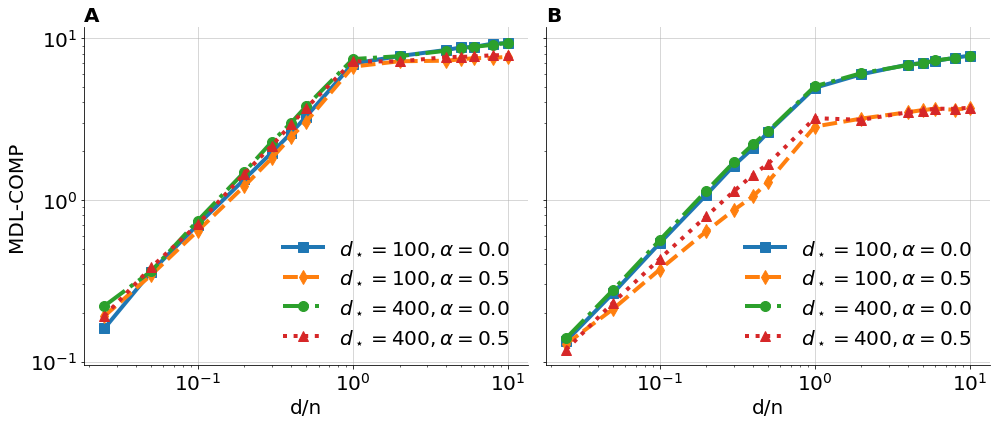

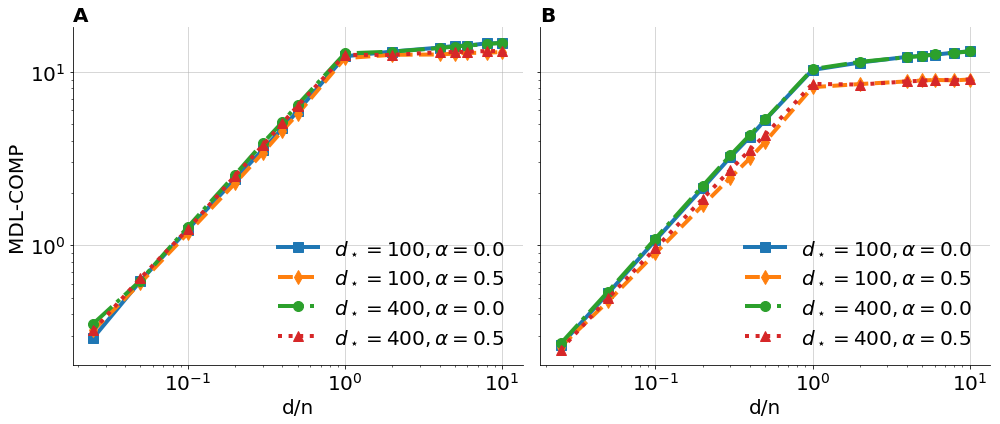

In [18]:
save_fig = True
axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[14, 6])
for ff, (file, noise_std) in enumerate(zip(['decay_mdl_n_200_noise_1.txt', 'decay_mdl_n_200_noise_0.txt'], [1, .1])):
    results = pickle.load(open(file, 'rb'))
    
    num_norms = results["num_norms"]
    d0s = results["d0s"]
    ns = results["ns"]
    ds = results["ds"]
    rmt_mdl_comp = results["rmt_mdl_comp"]
    rmt_mdl_comp_2 = results["rmt_mdl_comp_2"]
    rmt_mdl_comp_3 = results["rmt_mdl_comp_3"]


    lss = ['-', '--', '-.', ':']
    mss = ['s', 'd', 'o', '^']
    n = ns[0]
    gammas = ds/n

    for i in range(1):
        ax = axes[1][ff]
        ax.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 0, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[0]))
        ax.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 0, 1],   color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[1]))
        ax.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 1, 0],   color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[0]))
        ax.loglog(gammas, rmt_mdl_comp_2.mean(0)[i, :, 0, 1, 1],   color=cs[3], linestyle=lss[3], linewidth=4.,  marker=mss[3],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[1]))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if ff == 0:
            ax.set_title('A', loc='left', fontsize=20, fontweight='bold')
            ax.set_ylabel("MDL-COMP")
        else:
            ax.set_title('B', loc='left', fontsize=20, fontweight='bold')
        ax.grid(True, alpha=0.5, linewidth=1.)
        ax.legend(frameon=False, fontsize=20) 
        ax.set_xlabel('d/n')
plt.tight_layout()
if save_fig:
    plt.savefig('fig3/gauss_results_n_%d.pdf'%(n))
plt.show()


axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[14, 6])
for ff, (file, noise_std) in enumerate(zip(['decay_mdl_n_200_noise_1.txt', 'decay_mdl_n_200_noise_0.txt'], [1, .1])):
    results = pickle.load(open(file, 'rb'))
    
    num_norms = results["num_norms"]
    d0s = results["d0s"]
    ns = results["ns"]
    ds = results["ds"]
    rmt_mdl_comp = results["rmt_mdl_comp"]
    rmt_mdl_comp_2 = results["rmt_mdl_comp_2"]
    rmt_mdl_comp_3 = results["rmt_mdl_comp_3"]


    lss = ['-', '--', '-.', ':']
    mss = ['s', 'd', 'o', '^']
    n = ns[0]
    gammas = ds/n

    for i in range(1):
        ax = axes[1][ff]
        ax.loglog(gammas, rmt_mdl_comp_3.mean(0)[i, :, 0, 0, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[0]))
        ax.loglog(gammas, rmt_mdl_comp_3.mean(0)[i, :, 0, 0, 1],   color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[0], epows[1]))
        ax.loglog(gammas, rmt_mdl_comp_3.mean(0)[i, :, 0, 1, 0],   color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[0]))
        ax.loglog(gammas, rmt_mdl_comp_3.mean(0)[i, :, 0, 1, 1],   color=cs[3], linestyle=lss[3], linewidth=4.,  marker=mss[3],  markersize=10, label=r'$d_\star=%d, \alpha=%.1f$'%(d0s[1], epows[1]))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if ff == 0:
            ax.set_title('A', loc='left', fontsize=20, fontweight='bold')
            ax.set_ylabel("MDL-COMP")
        else:
            ax.set_title('B', loc='left', fontsize=20, fontweight='bold')
        ax.grid(True, alpha=0.5, linewidth=1.)
        ax.legend(frameon=False, fontsize=20) 
        ax.set_xlabel('d/n')
plt.tight_layout()
if save_fig:
    plt.savefig('fig3/gauss_results_delta_n_%d.pdf'%(n))
plt.show()

In [57]:
def loc_calc_thetahat(l):
    inv = scl.pinv(X_train_d.T @ X_train_d + l * np.eye(d))
#     inv = eigenvecs @ npl.pinv(np.eye(d) + np.diag(eigenvals)) @ eigenvecs.T
    return inv @ X_train_d.T @ y_train_n

def loc_mdl1_loss(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train_n - X_train_d @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return (mse_norm + theta_norm + eigensum) / n


def loc_mdl1_loss_ret_all(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train_n - X_train_d @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return mse_norm/n , theta_norm/n,  eigensum / n

def g(a, b):
    val = np.sqrt(a*(1+np.sqrt(b))**2+1)
    val -= np.sqrt(a*(1-np.sqrt(b))**2+1)
    val = val**2
    return(val/4)

def thm3(gammas, snr):
    delta = g(snr, gammas)
    bnd = gammas * np.log(1+snr-delta)
    bnd += np.log(1+gammas * snr - delta)
    bnd -= delta/snr
    return(bnd)

In [58]:
results = pickle.load(open('prac_mdl_n_200_noise_0.txt', 'rb'))

# results = pickle.load(open('prac_mdl_n_%d_noise_%d.txt'%(ns[0], noise_std), 'rb'))
save_fig = False

ds = results["ds"]
ns = results["ns"]
d0s = results["d0s"]
rmt_mdl_comp = results["rmt_mdl_comp"]
eigsum  = results["eigsum"]
n = ns[0]
gammas = ds/n

lss = ['-', '--', '-.', ':']
mss = ['s', 'd', 'o', '^']

for i in range(1):
    for l, d0 in enumerate(d0s):
        plt.figure(figsize=[8, 6])

        plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, l, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label='MDL-COMP (Thm1)')
        plt.loglog(gammas, thm3(gammas, np.minimum(d0,ds)/ds),  color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1], markersize=10, label='MDL-COMP (Thm2)')
        plt.loglog(gammas, eigsum.mean(0)[i, :, 0, l, 0], color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2], markersize=10, label= 'Prac-MDL-COMP (Eigensum)')
        plt.grid(True, alpha=0.5, linewidth=1.)
#         plt.ylim([1e-3, 8e-1])
        plt.legend(frameon=False, fontsize=20) 
        plt.title(r'Different MDL-COMP ($n=%d, d_\star=%d$)'%(ns[0], d0), fontsize=20)
        plt.xlabel('d/n')
        plt.tight_layout()
        if save_fig:
            plt.savefig('fig3/prac_mdl_comp_norm_%d_n_%d_noise_%d_d0_%d.pdf'%((i+1)**2, n, noise_std, d0))
        plt.show()

KeyError: 'eigsum'